In [1]:
import torch
import os
import pickle
import numpy as np
import itertools
import librosa
import random
from random import shuffle
import codecs
import errno
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision.datasets.mnist
from torchvision import transforms
from tqdm import tqdm
import math

In [2]:
print(os.getcwd())

G:\Git\Deep Learning\Assignment4


In [3]:
file = open("hw4_trs.pkl",'rb')
train_data = pickle.load(file)
file.close()

file = open("hw4_tes.pkl",'rb')
test_data = pickle.load(file)
file.close()

In [4]:
train_data.shape
training = []

In [5]:
training = []
for sig in range(500):
    stft = librosa.stft(train_data[sig], n_fft=1024, hop_length=512)
    stft.resize((513,200))
    training.append(np.abs(stft).T)

In [6]:
training[0].shape

(200, 513)

In [7]:
test_data.shape

(200, 22631)

In [8]:
test_data

array([[ 0.00127268, -0.00018181,  0.00027272, ..., -0.00363621,
        -0.0034544 , -0.00418165],
       [-0.00023365,  0.00023365,  0.        , ..., -0.00700938,
        -0.00763243, -0.00957948],
       [ 0.0014514 , -0.00019352,  0.00029028, ..., -0.00232224,
        -0.00299957, -0.00261252],
       ...,
       [ 0.00022017,  0.00036695,  0.00014678, ...,  0.02803493,
         0.01812729,  0.00910034],
       [ 0.00011644,  0.00034932,  0.00034932, ..., -0.06386784,
        -0.08779645, -0.10881403],
       [ 0.00034393,  0.00080251,  0.00074519, ..., -0.00045858,
        -0.00424185, -0.00492971]], dtype=float32)

In [9]:
np.append(np.arange(3,10), np.arange(11,20))

array([ 3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [10]:
train_data[0:9,:].shape

(9, 16180)

In [11]:
positive_list = []
negative_list = []
m = [1,2,3]
print(shuffle(m))

None


In [34]:
positive_pairs = np.zeros((50,9,2))
negative_pairs = np.zeros((50,9,2))
person = np.zeros((50,9))
for i in range(50):
    complete_set = set(range(500))
    positive_set = set(range(i, i+10))
    negative_set = set(complete_set - positive_set)

    # print(list(positive_set))
    positive_list = list(positive_set)
    # print(len(positive_list))
    negative_list = list(negative_set)

    shuffle(positive_list)
    shuffle(negative_list)

    positive_combinations = np.array(random.sample(list(itertools.combinations(positive_list, 2)), 9) )
    negative_combinations = np.array(random.sample(list(itertools.product(positive_list, negative_list)), 9))
    positive_pairs[i] = positive_combinations
    negative_pairs[i] = negative_combinations
    person[i] = i

In [35]:
positive_pairs_reshaped = positive_pairs.reshape((50 * 9), 2)
negative_pairs_reshaped = negative_pairs.reshape((50 * 9), 2)
person = person.reshape((450, 1))

In [36]:
# for j in range(len(positive_pairs)):
# #     j will be from 0 to 50
#     positive_list = []
#     negative_list = []
#     for k in range(len(positive_pairs)):
        
#         pos_index1  =  positive_pairs[k][0]
#         pos_index2  =  positive_pairs[k][1]
#         print(pos_index2)
#         neg_index1  =  negative_pairs[k][0]
#         neg_index2  =  negative_pairs[k][1]
        
#         pos_pair = (train_data[pos_index1, :], train_data[pos_index2, :], math.floor(pos_index1 / 50))
#         neg_pair = (train_data[neg_index1, :], train_data[neg_index2, :], math.floor(pos_index1 / 50))
        
        

In [37]:
# ref: https://becominghuman.ai/siamese-networks-algorithm-applications-and-pytorch-implementation-4ffa3304c18


# class LSTM(nn.Module):
    
#     def __init__(self, input_size, hidden_size):
#         super(LSTM, self).__init__()
#         self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size)
#         self.linear = nn.Linear(hidden_size, 513)
#         self.act = torch.sigmoid
      
#     def forward(self, data):
#         res = []
#         for i in range(2): # Siamese nets; sharing weights
#             x = data[i]
#             print('data')
#             print(self.rnn)
#             pred, hidden = self.rnn(x[0])
#             pred = self.act(self.linear(pred)).view(pred.data.shape[0], BATCH, 513)
#             res.append(pred)
         
#         res = torch.abs(res[1] - res[0])
#         res = self.linear2(res)
#         return res

In [38]:
train_positive_pair_loader = torch.utils.data.DataLoader(positive_pairs_reshaped, batch_size=1)
train_negative_pair_loader = torch.utils.data.DataLoader(negative_pairs_reshaped, batch_size=1)
train_label_loader = torch.utils.data.DataLoader(person, batch_size=1)

In [39]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

positive loass
tensor(7.1998e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
posi

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0.

tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
t

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0.

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tens

tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tens

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
t

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0.

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0.

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tens

tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tens

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0.

tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
t

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0.

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tens

tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tens

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
t

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0.

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0.

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(2.5000e-05, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
positive loass
tensor(-0.0001, device='cuda:0', grad_fn=<NllLossBackward>)
negative loss
tens

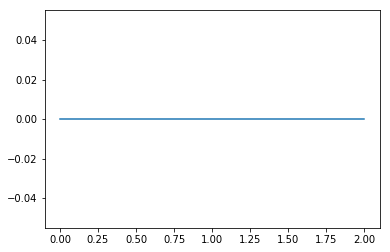

1353


In [48]:
# using Adam with learning rat .001 keeping everything else default.
class LSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size)
        self.linear1 = nn.Linear(hidden_size, 513)
        
        self.linear2 = nn.Linear(513, 1)
        self.act = nn.RReLU(0, 1)
        
    def forward(self, data):
#         pred, hidden = self.rnn(x, None)
#         pred = self.act(self.linear(pred)).view(pred.data.shape[0], BATCH, 513)
        res = []
        for i in range(2): # Siamese nets; sharing weights
            x = torch.tensor(data[i]).cuda()
            pred, hidden = self.rnn(x[np.newaxis, :, :])
            pred = self.act(self.linear1(pred))
            res.append(pred)
         
        res = torch.abs(res[1] - res[0])
        res = self.linear2(res)
        return res

neural_network = LSTM(513,256)
neural_network = neural_network.cuda()
loss_function= nn.CrossEntropyLoss()
para = neural_network.parameters()
optimizer = torch.optim.Adam(params=para, lr=0.001)
loss_list = []
epochs = 3
# count = 0
for i in range(epochs):
    positive_pairs = iter(train_positive_pair_loader)
    negative_pairs = iter(train_negative_pair_loader)
    labels = iter(train_label_loader)
    while True:
        try:
#             count = count + 1
            positive_sets = positive_pairs.next()[0]
            negative_sets = negative_pairs.next()[0]
#             print('positive set')
#             print(positive_sets)
#             print('negative set')
#             print(negative_sets)
            target = labels.next()[0]
#             print(target)
            positive_tensors = [training[int(positive_sets[0].numpy())],training[int(positive_sets[1].numpy())]]
            negative_tensors = [training[int(positive_sets[0].numpy())],training[int(negative_sets[1].numpy())]]
#             print(positive_tensors[0].shape)
            optimizer.zero_grad()

            positive_set_output  = neural_network(positive_tensors).reshape(200,1)
            negative_set_output  = neural_network(negative_tensors).reshape(200,1)
#             print(positive_set_output.shape)
#             print(positive_set_output.shape)
            loss_positive = F.cross_entropy(positive_set_output , np.repeat(torch.tensor(1),200).type(torch.LongTensor).cuda())
            loss_negative = F.cross_entropy(negative_set_output , np.repeat(torch.tensor(0),200).type(torch.LongTensor).cuda())
            print('positive loass')
            print(loss_positive)
            print('negative loss')
            print(loss_negative)
            loss = loss_positive + loss_negative
#             print(loss)
            loss.backward()
            optimizer.step()
        except StopIteration:
            break
    loss_list.append(loss.data.cpu().numpy())
print(loss.data)
plt.plot(range(epochs), loss_list)
plt.show() 
print(count)